Set up

In [1]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

create training data

In [4]:
data = pd.read_csv("data/next_step_data.csv")

In [5]:
data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
0,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513443e+09
1,2171.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
2,2171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,0.0,1.513444e+09
3,2171.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
4,2171.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.21,NaN,0.630,NaN,NaN,NaN,NaN,NaN,1.0,1.515096e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835360,568669.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687208e+09
5835361,568669.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687210e+09
5835362,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.00,0.882,0.667,0.846,1.0,0.188,0.827,NaN,1.0,1.687211e+09
5835363,568669.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,0.882,0.667,0.846,1.0,0.218,0.827,NaN,1.0,1.687216e+09


In [6]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
# n_samples = 100000

## one sample for train, only to see if it learns that one example
# test_data = test_data[:n_samples].copy()

In [7]:
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.0,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,321071.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887,1.0,1.579381e+09
5025510,312055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089,1.0,1.563748e+09
870943,81648.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,1.0,1.528247e+09
5732377,354946.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.754,NaN,0.273,0.286,0.987,1.0,1.581274e+09


In [8]:
# specific sessions to track
# session_id = [4478682, 5198989, 3511929, 4134494, 217809, 108777, 4313511, 4184746, 3694380, 2051828, 5151980, 5447081, 3640067, 4856734, 5313162, 4203617, 1813788, 3485634, 4876271, 2213497, 5025916, 274747, 4621927, 3888559, 2592816, 4325322, 3673390]
# test_data = test_data.loc[session_id]

model set up

In [9]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [10]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    print("===== from create_model_data ======")
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    print("data_scores: ", data_scores)
    print("target: ", target)
    return data_scores, target

In [11]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [12]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [13]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

filter out the non-repeats first for ground truth as the base set

In [14]:
# find whether it is a repeat domain or not
def assign_repeat(df):
    print("================= assign_repeat =============")
    # default to false
    df[repeat_columns] = True
    for idx, row in df.iterrows():
        assignment = True
        # print("the row ", row)
        for encoding_col, score_col in zip(encoding_columns, score_columns):
            # print("columns:" , encoding_col, score_col)
            # Find rows where encoding column is 1
            encoding_is_1 = row[encoding_col] == 1
            
            # Check if the corresponding score column is NaN for those rows
            is_nan = pd.isna(row[score_col])
            # print("encoding is 1 and is nan: ", encoding_is_1, is_nan)
            # Combine the conditions: where encoding column is 1 and score column is NaN
            condition = encoding_is_1 & is_nan
            # print("condition: ", condition)
            if condition:
                assignment = False
                break
            
        # Set the 'repeat' column to True where the condition is met, False otherwise
        # print("assignment: ", assignment)
        df.loc[idx, 'repeat'] = assignment
    # print("after assignment: ", df)
    return df

In [15]:
test_data_assigned  = assign_repeat(test_data)

================= assign_repeat =============


In [16]:
test_data_nonrepeat = test_data_assigned[test_data_assigned.repeat == False].copy()

In [17]:
# make test data copies
ground_truth_test_data = test_data_nonrepeat.copy()
random_test_data = test_data_nonrepeat.copy()
best_test_data = test_data_nonrepeat.copy()

In [18]:
ground_truth_test_data.shape

(8738, 45)

create encoding and find prediction

In [19]:
# return predictions, loss, and mae
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [20]:
def create_random_encoding(df):
    """
    Returns a numpy array of the same shape as df with 0s everywhere except for 
    a randomly chosen NaN position in each row, which is marked with a 1.

    Parameters:
    df (pd.DataFrame): Input dataframe.

    Returns:
    np.ndarray: Array with the same shape as df, containing 0s and a single 1 in a NaN position per row.
    """
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Create an output array of zeros
    output = np.zeros(df.shape, dtype=int)

    # Iterate over each row
    for i, row in enumerate(df.isna().values):
        nan_indices = np.where(row)[0]  # Find indices where NaN is present
        if len(nan_indices) > 0:
            chosen_index = np.random.choice(nan_indices)  # Pick one at random
            output[i, chosen_index] = 1  # Set the chosen position to 1
    
    return output


In [21]:
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions = predict(model, x_random, torch.from_numpy(y).float())
    return predictions, e

In [22]:
# create random encoding
random_encoding = create_random_encoding(random_test_data[score_columns])
random_test_data[encoding_columns] = random_encoding

In [23]:
# find random prediction
random_prediction, random_encoding = find_random_predictions(random_test_data)
random_test_data[target_columns] = random_prediction
random_test_data

===== from create_model_data ======
data_scores:  [[0.    0.    1.    ... 0.    0.    0.   ]
 [0.    0.    0.363 ... 0.721 1.    1.   ]
 [0.    0.    1.    ... 0.545 1.    1.   ]
 ...
 [1.    1.    1.    ... 1.    0.    0.   ]
 [0.881 0.119 1.    ... 0.636 0.914 0.086]
 [1.    1.    0.    ... 0.576 1.    1.   ]]
target:  [[nan nan nan ...  0. nan nan]
 [nan  0.  0. ... nan  0. nan]
 [nan nan  0. ... nan  0.  0.]
 ...
 [nan nan  0. ... nan  0. nan]
 [ 0. nan nan ...  0.  0.  0.]
 [nan nan  0. ...  0.  0. nan]]


,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
3673390,215842.0,0,0,0,0,0,0,1,0,0,...,0.549898,-0.011308,0.002429,-0.021834,-0.011557,0.004920,0.005814,0.005774,False,1.531091e+09
1813788,136357.0,0,0,0,0,0,0,0,0,1,...,-0.012451,-0.011513,0.401680,-0.011117,-0.002386,-0.004654,0.008537,0.004214,False,1.606356e+09
3640067,213781.0,0,0,0,0,0,0,0,0,0,...,-0.009517,-0.017154,0.016443,-0.000571,-0.000963,0.388914,0.002501,-0.001450,False,1.538802e+09
5313162,328299.0,0,0,0,0,0,0,0,0,0,...,-0.005558,0.008048,-0.002268,0.004365,0.002865,0.011723,0.006900,0.421348,False,1.571083e+09
2592816,164631.0,0,0,0,0,0,0,0,0,0,...,0.001972,-0.016614,-0.003692,0.009183,0.000709,-0.008161,0.329972,-0.000884,False,1.518536e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698560,169498.0,0,0,0,0,0,1,0,0,0,...,-0.003077,-0.007893,0.003284,0.003566,0.007075,-0.008501,-0.002336,-0.003053,False,1.520479e+09
1755348,133127.0,0,0,0,0,0,0,0,0,0,...,0.013612,0.003276,-0.002993,0.003044,-0.009874,0.500044,-0.009728,-0.005713,False,1.529696e+09
3073591,188475.0,0,0,0,1,0,0,0,0,0,...,0.000589,-0.003733,0.002997,0.007793,-0.002824,0.003979,0.000253,0.005008,False,1.528762e+09
3257637,196970.0,0,1,0,0,0,0,0,0,0,...,-0.005217,0.001406,-0.011425,0.014593,-0.001650,-0.023977,-0.008809,-0.013198,False,1.537201e+09


In [24]:
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [25]:
def predict_all_domains(x, y):
    prediction_list = []
    rows, cols = y.shape
    # loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
    for domain in range(14):
        encoding = create_single_encoding(rows, cols, domain)
        x_single = add_encoding(x, encoding)
        single_prediction = predict(model, x_single, torch.from_numpy(y).float())
        prediction_list.append(single_prediction[:, domain])
    return prediction_list

In [26]:
def find_best_idx_pred(x, y, original):
    prediction_lst = predict_all_domains(x, y)
    prediction_matrix = np.column_stack(prediction_lst)  # Shape: (100000, 14)
    difference = prediction_matrix - original
    # Find the index of the max difference for each row
    max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
    rows, cols = y.shape
    # Create a zero matrix of shape (100000, 14)
    encoding = np.zeros((rows, cols), dtype=int)
    # Assign 1s at the max_indices positions to create the full encoding matrix with best domains
    encoding[np.arange(rows), max_indices] = 1
    # create a zero matrix of shape (100000, 14)
    predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
    # Fill in the max values at their corresponding positions
    predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
    return encoding, predictions

In [27]:
def max_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    max_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    max_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            max_idx = np.argmax(valid_differences)  # Find index of max value (relative to valid_indices)
            max_indices[i] = valid_indices[max_idx]  # Store original column index
            max_values[i] = prediction_matrix[i, valid_indices[max_idx]]  # Get corresponding prediction value

    return max_values, max_indices

In [28]:
def reconstruct_max_matrices(max_values, max_indices, shape):
    max_values_matrix = np.zeros(shape)  # Matrix for max values
    max_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(max_indices[i]):  # Ensure there's a valid index
            col_idx = int(max_indices[i])
            max_values_matrix[i, col_idx] = max_values[i]
            max_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return max_values_matrix, max_indices_matrix

In [29]:
# create best encoding
x_tmp, y_tmp = create_model_data(best_test_data) # create scores with missing indicators and target
rows, cols = y_tmp.shape
prediction_list = []
# loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = add_encoding(x_tmp, encoding)
    print("data put in model", tmp_single)
    single_prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

===== from create_model_data ======
data_scores:  [[0.    0.    1.    ... 0.    0.    0.   ]
 [0.    0.    0.363 ... 0.721 1.    1.   ]
 [0.    0.    1.    ... 0.545 1.    1.   ]
 ...
 [1.    1.    1.    ... 1.    0.    0.   ]
 [0.881 0.119 1.    ... 0.636 0.914 0.086]
 [1.    1.    0.    ... 0.576 1.    1.   ]]
target:  [[  nan   nan   nan ... 0.      nan   nan]
 [  nan 0.    0.    ...   nan 0.      nan]
 [  nan   nan 0.    ...   nan 0.    0.7  ]
 ...
 [  nan   nan 0.4   ...   nan 0.424   nan]
 [0.      nan   nan ... 0.    0.    0.   ]
 [  nan   nan 0.    ... 0.    0.      nan]]
============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.7210, 1.0000, 1.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.5450, 1.0000, 1.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..

In [30]:
x_tmp

array([[0.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.363, ..., 0.721, 1.   , 1.   ],
       [0.   , 0.   , 1.   , ..., 0.545, 1.   , 1.   ],
       ...,
       [1.   , 1.   , 1.   , ..., 1.   , 0.   , 0.   ],
       [0.881, 0.119, 1.   , ..., 0.636, 0.914, 0.086],
       [1.   , 1.   , 0.   , ..., 0.576, 1.   , 1.   ]])

In [31]:
prediction_list

[array([0.59559923, 0.44034404, 0.41454268, ..., 0.39142716, 0.7882579 ,
        0.33084536], dtype=float32),
 array([0.66906124, 0.31707934, 0.38875777, ..., 0.44158828, 0.43192232,
        0.406963  ], dtype=float32),
 array([0.777784  , 0.32634768, 0.44275782, ..., 0.29485327, 0.34376237,
        0.35698766], dtype=float32),
 array([0.60730094, 0.35357934, 0.18735886, ..., 0.4784879 , 0.25774598,
        0.18582886], dtype=float32),
 array([0.5184592 , 0.17237446, 0.10274861, ..., 0.42178813, 0.13841608,
        0.08967262], dtype=float32),
 array([0.42329186, 0.36559716, 0.6293499 , ..., 0.47247976, 0.76790845,
        0.37825078], dtype=float32),
 array([0.54989797, 0.08792218, 0.43596843, ..., 0.4196537 , 0.37524697,
        0.4827825 ], dtype=float32),
 array([0.6196399 , 0.3679698 , 0.04729078, ..., 0.45734587, 0.5623415 ,
        0.3413425 ], dtype=float32),
 array([0.55629456, 0.40168023, 0.23839685, ..., 0.43147215, 0.44455293,
        0.39661923], dtype=float32),
 array([0.

In [32]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)
difference = prediction_matrix - np.nan_to_num(best_test_data[score_columns].to_numpy())

# find max indices
max_values, max_indices = max_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
best_predictions, best_encoding = reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

'''
rows, cols = prediction_matrix.shape
# Find the index of the max difference for each row
max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
# Create a zero matrix of shape (100000, 14)
best_encoding = np.zeros((rows, cols), dtype=int)
# Assign 1s at the max_indices positions to create the full encoding matrix with best domains
best_encoding[np.arange(rows), max_indices] = 1
# create a zero matrix of shape (100000, 14)
best_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
# Fill in the max values at their corresponding positions
best_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
'''

'\nrows, cols = prediction_matrix.shape\n# Find the index of the max difference for each row\nmax_indices = np.argmax(difference, axis=1)  # Shape: (100000,)\n# Create a zero matrix of shape (100000, 14)\nbest_encoding = np.zeros((rows, cols), dtype=int)\n# Assign 1s at the max_indices positions to create the full encoding matrix with best domains\nbest_encoding[np.arange(rows), max_indices] = 1\n# create a zero matrix of shape (100000, 14)\nbest_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type\n# Fill in the max values at their corresponding positions\nbest_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]\n'

In [33]:
prediction_matrix

array([[0.59559923, 0.66906124, 0.777784  , ..., 0.41701466, 0.693161  ,
        0.5543561 ],
       [0.44034404, 0.31707934, 0.32634768, ..., 0.50488746, 0.2918178 ,
        0.41700384],
       [0.41454268, 0.38875777, 0.44275782, ..., 0.3889135 , 0.4277186 ,
        0.4356607 ],
       ...,
       [0.39142716, 0.44158828, 0.29485327, ..., 0.5005476 , 0.3416897 ,
        0.5528752 ],
       [0.7882579 , 0.43192232, 0.34376237, ..., 0.75160867, 0.3666317 ,
        0.8973392 ],
       [0.33084536, 0.406963  , 0.35698766, ..., 0.19788814, 0.3860559 ,
        0.39835384]], dtype=float32)

In [34]:
ground_truth_test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
3673390,NaN,NaN,NaN,0.071,NaN,NaN,NaN,NaN,NaN,0.036,NaN,0.357,NaN,NaN
1813788,NaN,0.363,0.345,0.413,0.205,NaN,0.056,NaN,NaN,0.185,NaN,NaN,0.279,NaN
3640067,NaN,NaN,0.467,0.214,0.050,0.684,NaN,0.000,0.25,0.286,NaN,NaN,0.455,0.700
5313162,0.357,NaN,0.507,0.214,0.050,NaN,NaN,NaN,NaN,0.372,0.8,0.200,0.394,NaN
2592816,NaN,NaN,0.400,NaN,NaN,0.684,NaN,0.000,NaN,NaN,NaN,NaN,0.424,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698560,0.429,NaN,0.733,0.286,0.100,NaN,NaN,NaN,0.25,0.571,1.0,0.250,0.455,NaN
1755348,0.429,0.550,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606,NaN
3073591,NaN,NaN,0.400,NaN,NaN,NaN,NaN,NaN,NaN,0.286,NaN,NaN,0.424,NaN
3257637,0.881,NaN,NaN,0.286,0.100,0.789,0.375,0.667,0.35,0.714,NaN,0.839,0.364,0.914


In [35]:
best_test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
3673390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357,NaN,NaN
1813788,NaN,0.363,0.345,0.413,0.205,NaN,0.056,NaN,NaN,NaN,NaN,NaN,0.279,NaN
3640067,NaN,NaN,0.467,0.214,0.050,0.684,NaN,0.000,0.25,0.286,NaN,NaN,0.455,NaN
5313162,0.357,NaN,0.627,0.214,0.050,NaN,NaN,NaN,NaN,0.372,0.8,0.200,NaN,NaN
2592816,NaN,NaN,NaN,NaN,NaN,0.684,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698560,0.429,NaN,0.733,0.286,0.100,NaN,NaN,NaN,NaN,0.571,1.0,0.250,0.455,NaN
1755348,0.429,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286,NaN,NaN,NaN,NaN
3257637,0.881,NaN,NaN,0.286,0.100,0.789,0.375,0.667,NaN,0.714,NaN,0.839,0.364,0.914


In [36]:
difference

array([[ 0.59559923,  0.66906124,  0.77778399, ...,  0.06001466,
         0.69316101,  0.5543561 ],
       [ 0.44034404, -0.04592066, -0.01865232, ...,  0.50488746,
         0.01281781,  0.41700384],
       [ 0.41454268,  0.38875777, -0.02424218, ...,  0.38891351,
        -0.02728139,  0.43566069],
       ...,
       [ 0.39142716,  0.44158828,  0.29485327, ...,  0.50054759,
         0.34168971,  0.55287522],
       [-0.0927421 ,  0.43192232,  0.34376237, ..., -0.08739133,
         0.00263169, -0.01666078],
       [ 0.33084536,  0.40696299, -0.04301234, ..., -0.01611186,
        -0.03794411,  0.39835384]])

In [37]:
max_indices

array([ 2., 11.,  6., ..., 13., 10.,  6.])

In [38]:
best_encoding

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
best_predictions

array([[0.        , 0.        , 0.77778399, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.50488746, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.55287522],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
best_test_data[encoding_columns] = best_encoding
best_test_data[target_columns] = best_predictions

separate by repeat vs non repeat

In [41]:
# random assignment
print("ground truth")
ground_truth_test_data_final  = assign_repeat(ground_truth_test_data)
print("random")
random_test_data_final  = assign_repeat(random_test_data)
print("best")
best_test_data_final  = assign_repeat(best_test_data)

ground truth
================= assign_repeat =============
random
================= assign_repeat =============
best
================= assign_repeat =============


In [42]:
random_test_data_final[random_test_data_final.repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
3673390,215842.0,0,0,0,0,0,0,1,0,0,...,0.549898,-0.011308,0.002429,-0.021834,-0.011557,0.004920,0.005814,0.005774,False,1.531091e+09
1813788,136357.0,0,0,0,0,0,0,0,0,1,...,-0.012451,-0.011513,0.401680,-0.011117,-0.002386,-0.004654,0.008537,0.004214,False,1.606356e+09
3640067,213781.0,0,0,0,0,0,0,0,0,0,...,-0.009517,-0.017154,0.016443,-0.000571,-0.000963,0.388914,0.002501,-0.001450,False,1.538802e+09
5313162,328299.0,0,0,0,0,0,0,0,0,0,...,-0.005558,0.008048,-0.002268,0.004365,0.002865,0.011723,0.006900,0.421348,False,1.571083e+09
2592816,164631.0,0,0,0,0,0,0,0,0,0,...,0.001972,-0.016614,-0.003692,0.009183,0.000709,-0.008161,0.329972,-0.000884,False,1.518536e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698560,169498.0,0,0,0,0,0,1,0,0,0,...,-0.003077,-0.007893,0.003284,0.003566,0.007075,-0.008501,-0.002336,-0.003053,False,1.520479e+09
1755348,133127.0,0,0,0,0,0,0,0,0,0,...,0.013612,0.003276,-0.002993,0.003044,-0.009874,0.500044,-0.009728,-0.005713,False,1.529696e+09
3073591,188475.0,0,0,0,1,0,0,0,0,0,...,0.000589,-0.003733,0.002997,0.007793,-0.002824,0.003979,0.000253,0.005008,False,1.528762e+09
3257637,196970.0,0,1,0,0,0,0,0,0,0,...,-0.005217,0.001406,-0.011425,0.014593,-0.001650,-0.023977,-0.008809,-0.013198,False,1.537201e+09


filter depending on number of known domains

In [43]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [44]:
# debug print
def debug_filter_print(df):
    n = df.iloc[0][score_columns].isna().sum()
    total_sessions = df.shape[0]
    print("# of missing = %d, # of total sessions = %d" % (n, total_sessions))
    print(np.isnan(df[score_columns]).sum(axis=1).sum() == n * total_sessions)

In [45]:
ground_truth_test_data_n = dict()
random_test_data_n = dict()
best_test_data_n = dict()

In [46]:
for n in range(1, 14):
    print("======================= filter n missing: n = %d =========================" % n)
    print("============ ground truth ===============")
    tmp = filter_n_missing(ground_truth_test_data_final, n_missing=n)
    ground_truth_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============ random ================")
    tmp = filter_n_missing(random_test_data_final, n_missing=n)
    random_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= best ==================")
    tmp = filter_n_missing(best_test_data_final, n_missing=n)
    best_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

======================= filter n missing: n = 1 =========================
============ ground truth ===============
# of missing = 1, # of total sessions = 228
True
============ random ================
# of missing = 1, # of total sessions = 228
True
============= best ==================
# of missing = 1, # of total sessions = 228
True
======================= filter n missing: n = 2 =========================
============ ground truth ===============
# of missing = 2, # of total sessions = 420
True
============ random ================
# of missing = 2, # of total sessions = 420
True
============= best ==================
# of missing = 2, # of total sessions = 420
True
======================= filter n missing: n = 3 =========================
============ ground truth ===============
# of missing = 3, # of total sessions = 606
True
============ random ================
# of missing = 3, # of total sessions = 606
True
============= best ==================
# of missing = 3, # of total sessio

In [47]:
ground_truth_test_data_final[score_columns] ## all three should be the same -> current score shouldn't be modified

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
3673390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357,NaN,NaN
1813788,NaN,0.363,0.345,0.413,0.205,NaN,0.056,NaN,NaN,NaN,NaN,NaN,0.279,NaN
3640067,NaN,NaN,0.467,0.214,0.050,0.684,NaN,0.000,0.25,0.286,NaN,NaN,0.455,NaN
5313162,0.357,NaN,0.627,0.214,0.050,NaN,NaN,NaN,NaN,0.372,0.8,0.200,NaN,NaN
2592816,NaN,NaN,NaN,NaN,NaN,0.684,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698560,0.429,NaN,0.733,0.286,0.100,NaN,NaN,NaN,NaN,0.571,1.0,0.250,0.455,NaN
1755348,0.429,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286,NaN,NaN,NaN,NaN
3257637,0.881,NaN,NaN,0.286,0.100,0.789,0.375,0.667,NaN,0.714,NaN,0.839,0.364,0.914


In [48]:
random_test_data_final[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
3673390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357,NaN,NaN
1813788,NaN,0.363,0.345,0.413,0.205,NaN,0.056,NaN,NaN,NaN,NaN,NaN,0.279,NaN
3640067,NaN,NaN,0.467,0.214,0.050,0.684,NaN,0.000,0.25,0.286,NaN,NaN,0.455,NaN
5313162,0.357,NaN,0.627,0.214,0.050,NaN,NaN,NaN,NaN,0.372,0.8,0.200,NaN,NaN
2592816,NaN,NaN,NaN,NaN,NaN,0.684,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698560,0.429,NaN,0.733,0.286,0.100,NaN,NaN,NaN,NaN,0.571,1.0,0.250,0.455,NaN
1755348,0.429,0.550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286,NaN,NaN,NaN,NaN
3257637,0.881,NaN,NaN,0.286,0.100,0.789,0.375,0.667,NaN,0.714,NaN,0.839,0.364,0.914


score aggregate

In [49]:
def overall_avg_improvement_with_std(df):
    pred_score = df[target_columns].to_numpy()
    cur_score = df[score_columns].to_numpy()
    encoding = df[encoding_columns].to_numpy()

    print("prediction score: ", pred_score)
    print("current score: ", cur_score)
    print("encoding: ", encoding)

    pred_score = np.nan_to_num(pred_score, nan=0) * encoding
    cur_score = np.nan_to_num(cur_score, nan=0) * encoding
    assert pred_score.shape == cur_score.shape and cur_score.shape == encoding.shape

    # Compute improvement
    improvement = encoding * (pred_score - cur_score)

    # Extract nonzero values
    nonzero_improvement = improvement[improvement != 0]

    if len(nonzero_improvement) == 0:
        avg_improvement = 0
        std_dev = 0
        print("No sessions with nonzero improvement")
    else:
        avg_improvement = np.mean(nonzero_improvement)
        std_dev = np.std(nonzero_improvement, ddof=1)  # Using sample standard deviation (ddof=1)

        print("Number of predicted domains:", len(nonzero_improvement))
        print("Average improvement:", avg_improvement)
        print("Standard deviation:", std_dev)

    return avg_improvement, std_dev

In [50]:
nonrepeat_ground_truth_avg = []
nonrepeat_random_avg = []
nonrepeat_best_avg = []

nonrepeat_ground_truth_std = []
nonrepeat_random_std = []
nonrepeat_best_std = []

In [51]:
for n in range(1, 14):
    print("========= %d missing" % n)
    print("----ground truth----")
    # ground truth
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_nonrepeat) != 0:
        nonrepeat_ground_truth_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_ground_truth_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_ground_truth_avg.append(0)
        nonrepeat_ground_truth_std.append(0)

    print("----random----")
    # random
    temp_nonrepeat = random_test_data_n[n][random_test_data_n[n].repeat == False]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_random_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_random_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_random_avg.append(0)
        nonrepeat_random_std.appen(0)
    
    print("----best----")
    # best
    temp_nonrepeat = best_test_data_n[n][best_test_data_n[n].repeat == False]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_best_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_best_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
    else:
        nonrepeat_best_avg.append(0)
        nonrepeat_best_std.append(0)

========= 1 missing
----ground truth----
prediction score:  [[0.632 0.36  1.    ... 0.376 0.806 0.3  ]
 [0.429 0.05  1.    ... 0.286 0.582 0.554]
 [1.    0.    1.    ... 0.143 0.206 0.874]
 ...
 [0.863 0.47  0.815 ... 0.34  0.838 0.3  ]
 [0.357 0.39  0.4   ... 0.357 0.    0.467]
 [0.357 0.    1.    ... 0.243 0.345 0.674]]
current score:  [[0.632 0.36  1.    ... 0.376 0.806 0.3  ]
 [0.429   nan 1.    ... 0.286 0.582 0.554]
 [1.      nan 1.    ... 0.143 0.206 0.874]
 ...
 [0.863 0.47  0.815 ... 0.34  0.838   nan]
 [0.357 0.39  0.4   ... 0.357 0.    0.467]
 [0.357   nan 1.    ... 0.243 0.345 0.674]]
encoding:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Number of predicted domains: 246
Average improvement: 0.3846260162601626
Standard deviation: 0.3395652177657628
prediction score:  [[0.632 0.36  1.    ... 0.376 0.806 0.3  ]
 [0.429 0.05  1.    ... 0.286 0.582 0.554]
 [1.    0.  

Prediction accuracy

In [ ]:
def plot_error_by_nan_count_nonzero_only(prediction_matrix, ground_truth_df, metric="mae"):
    """
    Plots error per number of NaNs in score columns with error bars, considering only nonzero values.

    Parameters:
    prediction_matrix (np.ndarray): 2D NumPy array of predicted values.
    ground_truth_df (pd.DataFrame): DataFrame containing ground truth and score columns.
    metric (str): "mae" for Mean Absolute Error, "mse" for Mean Squared Error.
    """
    global score_columns  # List of score column names
    global target_columns  # List of target columns
    global encoding_columns  # List of encoding columns

    # new_df = pd.DataFrame(data=)

    mean_errors_list = []
    ground_truth_std_list = []
    nan_counts = list(range(1, 14))  # Checking sessions with 1 to 13 NaNs
    ground_truth_dict = dict()
    mean_data = []

    for n in nan_counts:
        filtered_df = filter_n_missing(ground_truth_df, n)  # Filter by NaN count
        
        if filtered_df.empty:  # Skip if no data
            assert(True)
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        # Correctly map DataFrame indices to NumPy indices
        valid_indices = ground_truth_df.index.get_indexer(filtered_df.index)
        valid_indices = valid_indices[valid_indices >= 0]  # Ensure only valid indices are used
        # print("valid indices shape: ", valid_indices.shape)
        # Extract matrices
        ground_truth_matrix = np.nan_to_num(filtered_df[target_columns].to_numpy()[filtered_df[encoding_columns].to_numpy() == 1])
        filtered_prediction_matrix = prediction_matrix[valid_indices][filtered_df[encoding_columns].to_numpy() == 1]

        # Ensure matrices have the same shape
        assert filtered_prediction_matrix.shape == ground_truth_matrix.shape, "Mismatch in matrix shapes"
        
        # Compute improvement (errors)
        errors = np.abs(filtered_prediction_matrix - ground_truth_matrix) if metric == "mae" else (filtered_prediction_matrix - ground_truth_matrix) ** 2

        # print("Shape of filtered_df for n = %d: %d" % (n, filtered_df.shape[0]))
        # Extract only nonzero errors
        nonzero_errors = errors
        nonzero_ground_truth = ground_truth_matrix

        ground_truth_dict[str(n)] = nonzero_ground_truth

        # print("number of domainss known total (might be more than number of sessions)", filtered_df[encoding_columns].to_numpy().sum())
        print("shape of nonzero_error: ", nonzero_errors.shape)
        print("shape of nonzero_ground_truth: ", nonzero_ground_truth.shape)

        if len(nonzero_errors) == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            mean_data.append(np.nan)
        else:
            mean_errors_list.append(np.mean(nonzero_errors))
            ground_truth_std_list.append(np.std(nonzero_ground_truth, ddof=1))  # Sample standard deviation
            mean_data.append(np.mean(nonzero_ground_truth))

    # Convert to numpy arrays
    mean_errors = np.array(mean_errors_list)
    error_std = np.array(ground_truth_std_list)
    # convert dictionary to dataframe for plotting
    plot_df = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.violinplot(data=plot_df, ax=axes)
    # axes.plot(plot_df.keys(), mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data - mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data + mean_errors, color="cyan")
    axes.plot(plot_df.keys(), mean_data, label="Ground Truth Mean", marker="x", color="red", linewidth=2)
    # plt.plot(nan_counts, error_std, label="ground truth std", marker="x")
    # plt.errorbar(nan_counts, mean_errors, yerr=error_std, fmt='-o', capsize=5, color='b', alpha=0.7)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Error")
    plt.title(f"Prediction {metric.upper()} and Ground Truth Std. Comparison")
    # plt.xticks(nan_counts)
    # plt.ylim(-np.nanmax(error_std) * 1.1, np.nanmax(mean_errors + error_std) * 1.1 if not np.isnan(np.nanmax(mean_errors)) else 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

In [53]:
x_tmp, y_tmp = create_model_data(ground_truth_test_data_final) # create scores with missing indicators and target
rows, cols = y_tmp.shape
encoding = ground_truth_test_data_final[encoding_columns].to_numpy()
print("encoding: ", encoding)
x_train_tmp = add_encoding(x_tmp, encoding)
print("data put in model", x_train_tmp)
ground_truth_prediction = predict(model, x_train_tmp, torch.from_numpy(y_tmp).float())

===== from create_model_data ======
data_scores:  [[0.    0.    1.    ... 0.    0.    0.   ]
 [0.    0.    0.363 ... 0.721 1.    1.   ]
 [0.    0.    1.    ... 0.545 1.    1.   ]
 ...
 [1.    1.    1.    ... 1.    0.    0.   ]
 [0.881 0.119 1.    ... 0.636 0.914 0.086]
 [1.    1.    0.    ... 0.576 1.    1.   ]]
target:  [[  nan   nan   nan ... 0.      nan   nan]
 [  nan 0.    0.    ...   nan 0.      nan]
 [  nan   nan 0.    ...   nan 0.    0.7  ]
 ...
 [  nan   nan 0.4   ...   nan 0.424   nan]
 [0.      nan   nan ... 0.    0.    0.   ]
 [  nan   nan 0.    ... 0.    0.      nan]]
encoding:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
data put in model tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7210, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.5450, 1.0000, 1.0000],
        ...,
        [0.0000, 0.0000

Plot Results

In [54]:
ground_truth_prediction.shape

(8738, 14)

In [55]:
ground_truth_prediction[encoding == 1].shape

(14748,)

shape of nonzero_error:  (327,)
shape of nonzero_ground_truth:  (327,)
shape of nonzero_error:  (627,)
shape of nonzero_ground_truth:  (627,)
shape of nonzero_error:  (971,)
shape of nonzero_ground_truth:  (971,)
shape of nonzero_error:  (1125,)
shape of nonzero_ground_truth:  (1125,)
shape of nonzero_error:  (1229,)
shape of nonzero_ground_truth:  (1229,)
shape of nonzero_error:  (1405,)
shape of nonzero_ground_truth:  (1405,)
shape of nonzero_error:  (1244,)
shape of nonzero_ground_truth:  (1244,)
shape of nonzero_error:  (1480,)
shape of nonzero_ground_truth:  (1480,)
shape of nonzero_error:  (1252,)
shape of nonzero_ground_truth:  (1252,)
shape of nonzero_error:  (1507,)
shape of nonzero_ground_truth:  (1507,)
shape of nonzero_error:  (1401,)
shape of nonzero_ground_truth:  (1401,)
shape of nonzero_error:  (1163,)
shape of nonzero_ground_truth:  (1163,)
shape of nonzero_error:  (1017,)
shape of nonzero_ground_truth:  (1017,)


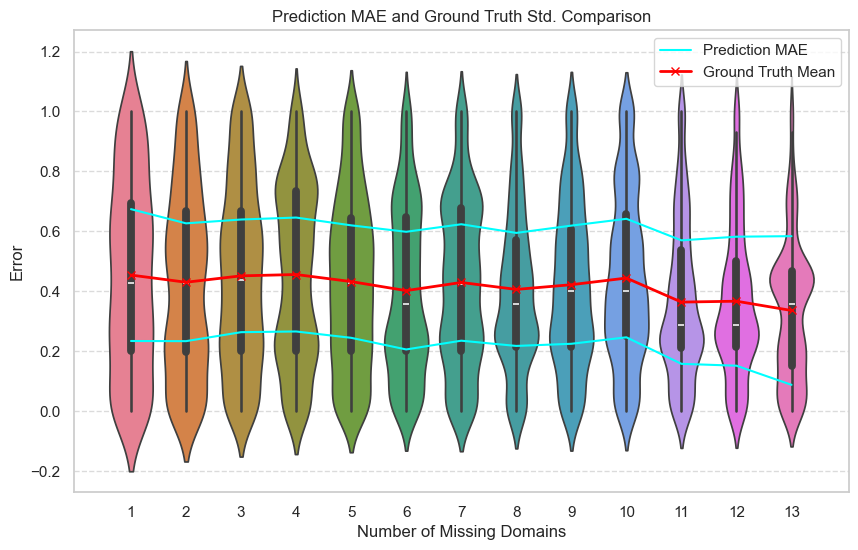

In [142]:
plot_error_by_nan_count_nonzero_only(ground_truth_prediction, ground_truth_test_data_final, metric="mae")  # Use "mse" for Mean Squared Error

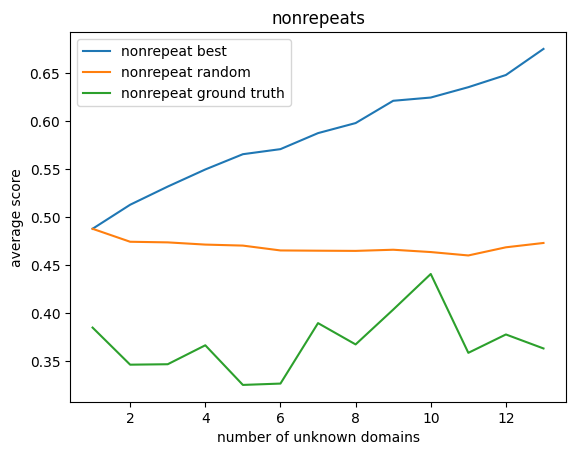

In [57]:
plt.figure()
plt.plot(range(1, 14), nonrepeat_best_avg, label="nonrepeat best")
plt.plot(range(1, 14), nonrepeat_random_avg, label="nonrepeat random")
plt.plot(range(1, 14), nonrepeat_ground_truth_avg, label="nonrepeat ground truth")
plt.xlabel("number of unknown domains")
plt.ylabel("average score")
plt.title("nonrepeats")
plt.legend()
plt.show()

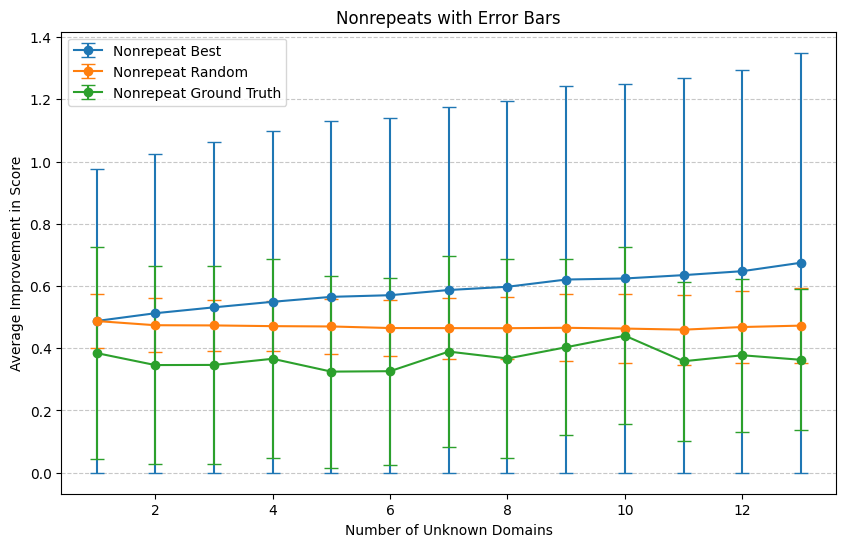

In [58]:
# Define x-axis values (number of unknown domains)
x_values = range(1, 14)

# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(x_values, nonrepeat_best_avg, yerr=nonrepeat_best_std, label="Nonrepeat Best", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_random_avg, yerr=nonrepeat_random_std, label="Nonrepeat Random", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_ground_truth_avg, yerr=nonrepeat_ground_truth_std, label="Nonrepeat Ground Truth", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Nonrepeats with Error Bars")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [155]:
def plot_violin_difference(ground_truth_data_df, random_data_df, best_data_df):
    ## set up variables
    ground_truth_dict = dict()
    random_dict = dict()
    best_dict = dict()

    ## go through data to obtain what's needed for plots
    for n in range(1, 14):
        print("========= %d missing" % n)
        ## set the variables for what we are working with
        print("----ground truth----")
        ground_truth_temp = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
        ground_truth_target_matrix = np.nan_to_num(ground_truth_temp[target_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        ground_truth_current_matrix = np.nan_to_num(ground_truth_temp[score_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        ground_truth_improvement = ground_truth_target_matrix - ground_truth_current_matrix
        ground_truth_dict[str(n)] = ground_truth_improvement
        
        print("----random----")
        random_temp = random_test_data_n[n][random_test_data_n[n].repeat == False]
        random_target_matrix = np.nan_to_num(random_temp[target_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        random_current_matrix = np.nan_to_num(random_temp[score_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        random_improvement = random_target_matrix - random_current_matrix
        random_dict[str(n)] = random_improvement

        print("----best----")
        best_temp = best_test_data_n[n][best_test_data_n[n].repeat == False]
        best_target_matrix = np.nan_to_num(best_temp[target_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        best_current_matrix = np.nan_to_num(best_temp[score_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        best_improvement = best_target_matrix - best_current_matrix
        best_dict[str(n)] = best_improvement

        ## assert and print statements for debugging
        # assert ground_truth_temp.shape == random_temp.shape and best_temp.shape == ground_truth_temp.shape, "shapes between don't match"

    ## create plot_df
    plot_df_ground_truth = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)
    plot_df_random = pd.concat(map(pd.Series, random_dict.values()), keys=random_dict.keys(), axis=1)
    plot_df_best = pd.concat(map(pd.Series, best_dict.values()), keys=best_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_ground_truth, ax=axes)
    # sns.violinplot(data=plot_df_random, ax=axes)
    # sns.violinplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Score")
    plt.title(f"Ground Truth Average Score Distribution by Number of Missing domains Violinplot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.violinplot(data=plot_df_random, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Score")
    plt.title(f"Random Average Score Distribution by Number of Missing domains Violinplot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.violinplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Score")
    plt.title(f"Best Average Score Distribution by Number of Missing domains Violinplot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

========= 1 missing
----ground truth----
----random----
----best----
========= 2 missing
----ground truth----
----random----
----best----
========= 3 missing
----ground truth----
----random----
----best----
========= 4 missing
----ground truth----
----random----
----best----
========= 5 missing
----ground truth----
----random----
----best----
========= 6 missing
----ground truth----
----random----
----best----
========= 7 missing
----ground truth----
----random----
----best----
========= 8 missing
----ground truth----
----random----
----best----
========= 9 missing
----ground truth----
----random----
----best----
========= 10 missing
----ground truth----
----random----
----best----
========= 11 missing
----ground truth----
----random----
----best----
========= 12 missing
----ground truth----
----random----
----best----
========= 13 missing
----ground truth----
----random----
----best----


/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_76899/748984348.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


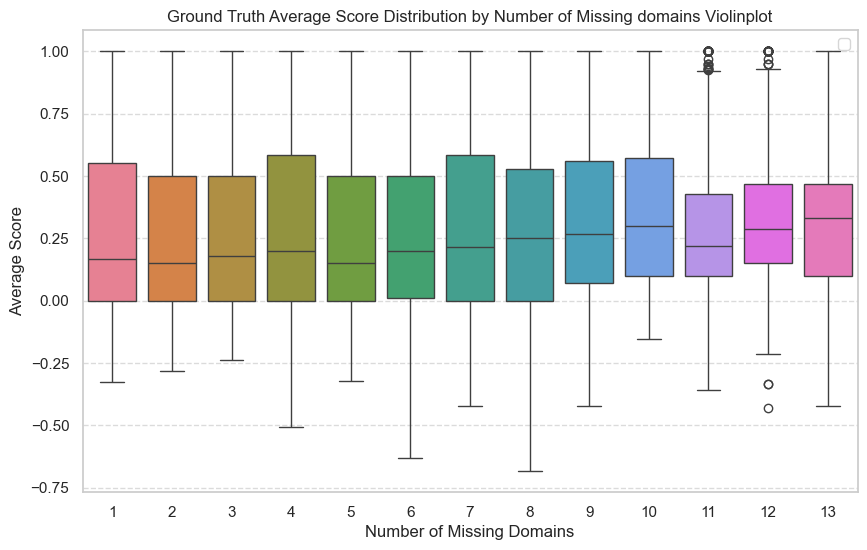

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_76899/748984348.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


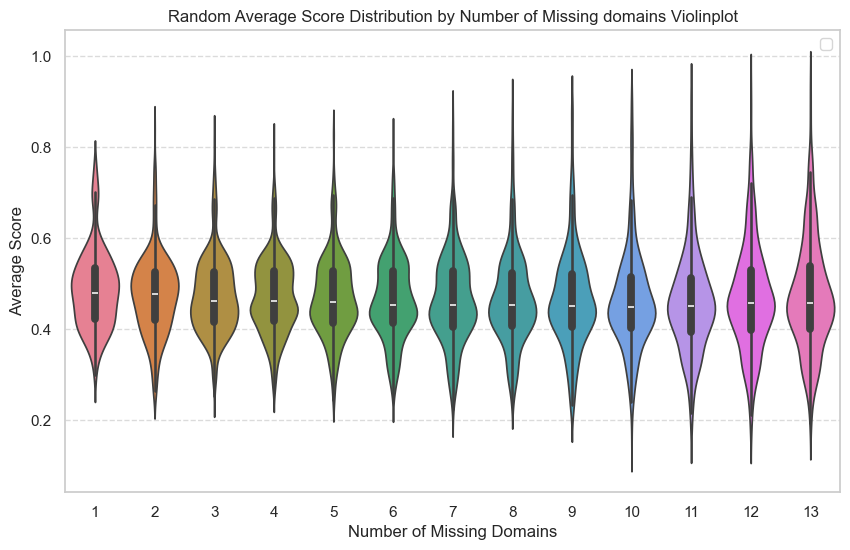

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_76899/748984348.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


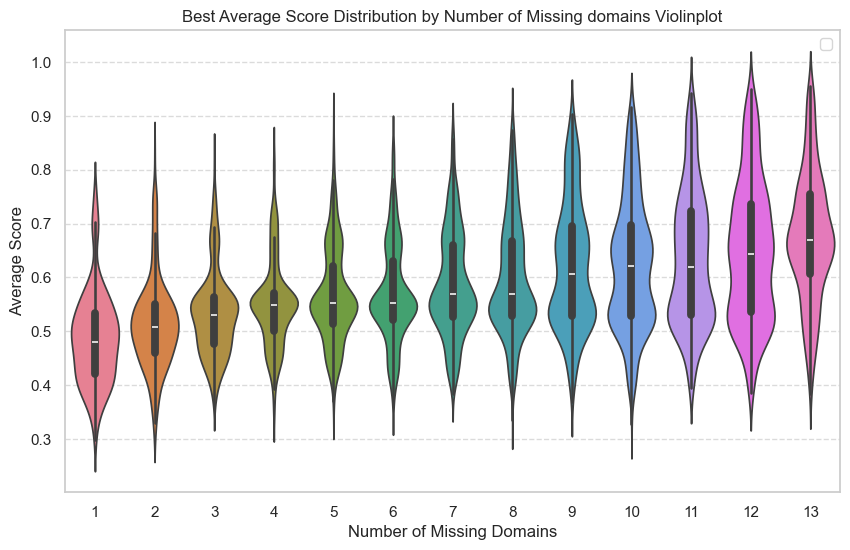

In [156]:
plot_violin_difference(ground_truth_test_data_final, random_test_data_final, best_test_data_final)

In [81]:
ground_truth_temp

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
3673390,215842.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.036,NaN,0.357,NaN,NaN,False,1.531091e+09
1550978,123923.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.522795e+09
3046060,187423.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.40,NaN,NaN,NaN,NaN,NaN,False,1.529313e+09
4283690,254506.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.455,NaN,False,1.549577e+09
771680,72899.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.35,NaN,NaN,NaN,0.752,NaN,False,1.512681e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515852,163237.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,0.083,NaN,NaN,NaN,NaN,NaN,NaN,False,1.522079e+09
1396972,113425.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.513012e+09
2864632,178333.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.455,NaN,False,1.524146e+09
1895797,138297.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.514,NaN,NaN,False,1.512660e+09


Bad pipe message: %s [b'\x0cV#\x16\xf2\x1d\x8f\x86\xdd\xa42\xbc\x04\xaa\xa3\xfa\x9f\xe2\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h']


In [76]:
temp_mask = (ground_truth_temp[encoding_columns] == 1).to_numpy()

In [77]:
temp_mask

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False,  True, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False,  True, False]])

In [82]:
ground_truth_temp[target_columns].to_numpy()[temp_mask]

array([0.071, 0.036, 0.429, ..., 0.772, 0.4  , 0.424])

trace

In [60]:
random_test_data_n[2][random_test_data_n[2].repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
217809,23495.0,0,0,0,0,0,0,0,0,0,...,-0.010873,0.003185,0.005774,0.003297,0.003315,0.003966,-0.008053,0.556610,False,1.577626e+09
3573512,210803.0,0,0,0,0,0,0,0,1,0,...,-0.006662,0.405713,-0.001409,0.002578,0.001937,0.009908,-0.012527,-0.000220,False,1.540062e+09
2483604,162533.0,0,1,0,0,0,0,0,0,0,...,-0.000499,0.003994,0.008451,0.006919,-0.000327,0.006821,-0.004899,0.002665,False,1.534457e+09
233096,26001.0,0,0,0,0,0,0,0,1,0,...,0.003451,0.443702,-0.033084,-0.004548,0.014193,-0.003275,0.012288,0.017824,False,1.513859e+09
4775755,290268.0,0,1,0,0,0,0,0,0,0,...,0.001720,0.016936,-0.005553,0.001145,0.003294,0.006212,-0.002050,-0.006580,False,1.568565e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736982,285854.0,0,1,0,0,0,0,0,0,0,...,0.004389,0.001521,0.005201,0.000253,0.000684,0.003175,0.004524,0.004862,False,1.565633e+09
4706719,282321.0,0,1,0,0,0,0,0,0,0,...,-0.006653,0.006234,0.000412,-0.002082,0.002697,-0.007103,-0.006762,-0.006338,False,1.565462e+09
4846373,298743.0,0,1,0,0,0,0,0,0,0,...,0.002776,0.015990,-0.009669,0.002895,0.009642,0.005732,0.006808,-0.006213,False,1.584287e+09
1043271,92268.0,0,0,0,0,0,0,0,1,0,...,0.006641,0.527659,-0.001632,-0.005123,-0.000144,-0.005897,-0.001858,0.005079,False,1.540926e+09


In [61]:
best_test_data_n[2][best_test_data_n[2].repeat == False]

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
217809,23495.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.556610,False,1.577626e+09
3573512,210803.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.443484,False,1.540062e+09
2483604,162533.0,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,False,1.534457e+09
233096,26001.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.650917,0.0,0.0,0.000000,False,1.513859e+09
4775755,290268.0,0,0,1,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,False,1.568565e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736982,285854.0,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,False,1.565633e+09
4706719,282321.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,False,1.565462e+09
4846373,298743.0,0,0,0,0,0,0,1,0,0,...,0.619867,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,False,1.584287e+09
1043271,92268.0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.563477,False,1.540926e+09


trace

In [62]:
session_id = []

In [63]:
test_data[encoding_columns].head(1)

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding
5198989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
ids = []

In [65]:
for n in range(1, 14):
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_repeat) != 0:
        ids.append(temp_repeat.index[0])
    if len(temp_nonrepeat) != 0:
        ids.append(temp_nonrepeat.index[0])

In [66]:
ids

[3511929,
 217809,
 4313511,
 3694380,
 5151980,
 3640067,
 5313162,
 1813788,
 4876271,
 5025916,
 4621927,
 2592816,
 3673390]